import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda"
import theano

In [1]:
import sys
if '/' in sys.path[0]:
    sys.path.append(r'/home/elisa/PycharmProjects/gempy')
elif '\\' in sys.path[0]:
    sys.path.append(r'C:/users/elisa/documents/git/gempy')

import gempy as gp
#import vtk


import numpy as np
import matplotlib.pyplot as plt

C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implemen

In [2]:
# for plotting
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', linewidth=1)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### 1. Regular model setup

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular' 'topography' 'sections']


Grid Object. Values: 
array([[ 166.66666667,  166.66666667,  166.66666667],
       [ 166.66666667,  166.66666667,  500.        ],
       [ 166.66666667,  166.66666667,  833.33333333],
       ...,
       [1000.        ,  200.        ,  974.6835443 ],
       [1000.        ,  200.        ,  987.34177215],
       [1000.        ,  200.        , 1000.        ]])

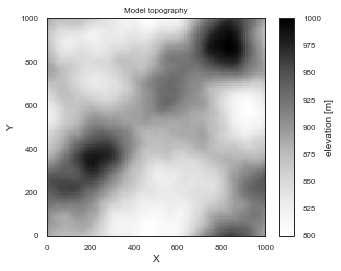

In [3]:
geo_model = gp.create_model('FaultModel')
gp.init_data(geo_model, extent=[0,1000,0,1000,0,1000],resolution = [3,3,3],
                         path_i = r"data/faultuncertainty_interfaces_surface.csv",
                         path_o = r"data/faultuncertainty_orient_surface.csv")

gp.map_series_to_surfaces(geo_model, {'fault_series':'fault','form_series':('layer2','layer1','basement')})
geo_model.surfaces.colors.change_colors({'layer1': '#ffbe00', 'layer2': '#9f0052', 'fault': '#015482',
                                        'basement': '#728f02'})

geo_model.set_is_fault(['fault_series'],change_color=False)

geo_model.set_section_grid({'s1':([0,200],[1000,200],[80,80])})#p1,p2,resolution
geo_model.set_topography(source='saved', filepath=r'data/topo.npy')

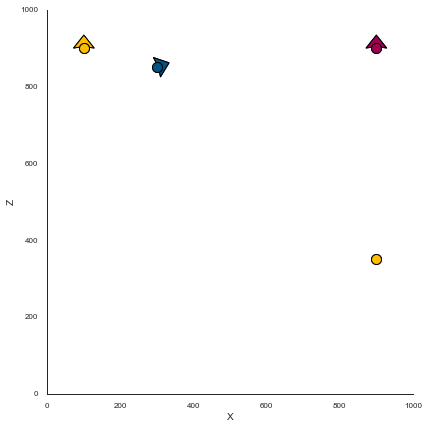

In [4]:
gp.plot.plot_data(geo_model, direction='y')

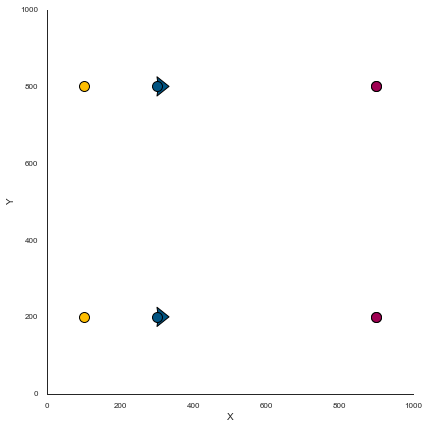

In [5]:
gp.plot.plot_data(geo_model, direction='z')

In [6]:
gp.set_interpolation_data(geo_model,
                          compile_theano=True,
                          theano_optimizer='fast_compile',
                          verbose=[])

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                   values
range            1732.05
$C_o$            71428.6
drift equations   [3, 3]


In [7]:
sol = gp.compute_model(geo_model, compute_mesh=False)

1000
0


C:/users/elisa/documents/git/gempy\gempy\plot\visualization_2d.py:208: UserWarning: the orientations are not converted to apparent dip.
  warnings.warn('the orientations are not converted to apparent dip.')


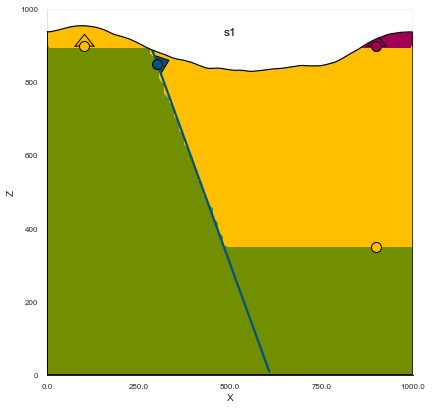

In [8]:
_=gp.plot.plot_section_by_name(geo_model, 's1', show_data=True, radius=50)

C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'zlevel'
  s)


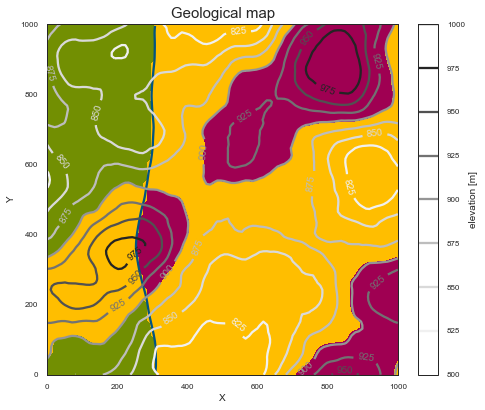

In [9]:
gp.plot.plot_map(geo_model, show_data=False, figsize=(7,7))

### 2. Stochastic simulation

### Define random functions for input data

In [10]:
##### Orientation uncertainty

In [11]:
import gempy.utils.fishdist as fish

def create_vMF_list(geo_model, kappas, datatype = 'all'):
    faultsdf = geo_model.faults.df
    orientdf = geo_model.orientations.df
    vMF_list=[]
    if datatype == 'faultsonly':
        faults=list(faultsdf[faultsdf['isFault']==True].index)
        df = orientdf[orientdf.series.isin(faults)]
    elif datatype == 'lithonly':
        notfaults = list(faultsdf[faultsdf['isFault']==False].index)
        df = orientdf[orientdf.series.isin(notfaults)]
    elif datatype == 'all':
        df = orientdf
    else:
        print('nö.')
    for e, i in df[['G_x', 'G_y', 'G_z']].iterrows():
        a=0
        vMF_list.append(fish.vMF('vMF_' + str(e), mean=i[['G_x', 'G_y', 'G_z']].values, kappa=kappas[a]))
        a+=1
    return vMF_list


# make a copy of the initial dataframe
orient = geo_model.orientations.df.copy()
# define concentration parameter for input data
kappadict = {'layer2':10, 'layer1':10, 'fault': 20}

#assign kappa values to the copied dataframe
for surface, kappa in kappadict.items():
    orient.loc[orient['surface'] == surface, 'kappa'] = kappa

# --> orient has new column with kappa
# take only kappa values (they are in right order now)
kappas = orient['kappa']

vMF_list=create_vMF_list(geo_model, kappas, datatype = 'faultsonly')

To fit a spherical distribution to the orientation measurements, spherecluster must be installed.


### Full simulation in loop with probability calculation

In [12]:
from tqdm import tqdm_notebook as tqdm
from gempy.utils import section_utils

##### Init probability blocks

In [13]:
# unique lith ids
lith_id = np.unique(np.round(geo_model.solutions.sections[0]).astype(int))

# setup solution arrays
geomap  = np.round(geo_model.solutions.geological_map[0]).astype(int).ravel()
section1  = np.round(geo_model.solutions.sections[0]).astype(int).ravel()
block = np.round(geo_model.solutions.lith_block).astype(int)

#init counters
count_map = np.zeros((len(lith_id), geomap.shape[0]))
count_section = np.zeros((len(lith_id), section1.shape[0]))
count_block = np.zeros((len(lith_id), block.shape[0]))

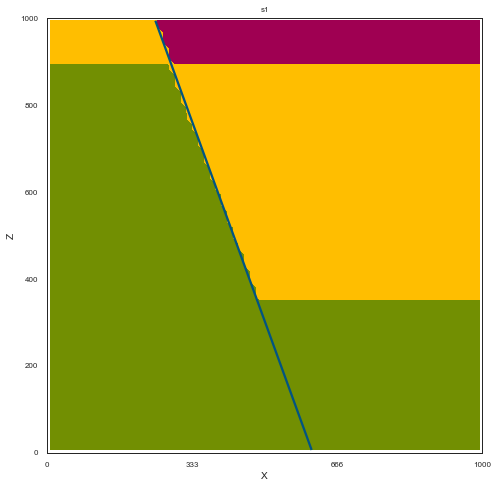

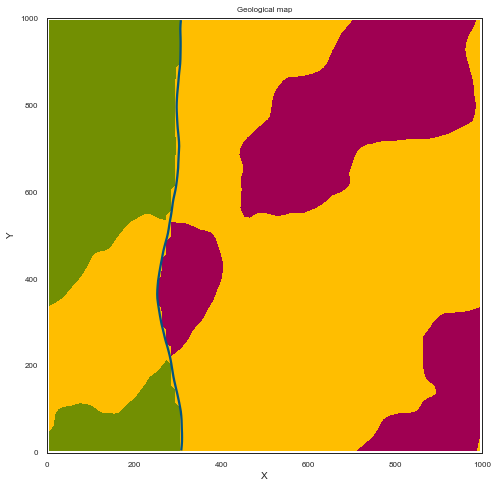

In [14]:
# init spaghetti plot
polygondict_s1, cdict, extent = section_utils.get_polygon_dictionary(geo_model, 's1')
polygondict_map, cdict, extent = section_utils.get_polygon_dictionary(geo_model, 'topography')

In [15]:
# perturb only location and orientation of fault
mask_orient = geo_model.orientations.df.surface.isin(['fault'])
indexes_or = geo_model.orientations.df[mask_orient].index
mask_surfpoints = geo_model.surface_points.df.surface.isin(['fault'])
indexes = geo_model.surface_points.df[mask_surfpoints].index

In [16]:
# copy initial dataframes to reset data before every iteration
import copy

west_east = copy.copy(geo_model.surface_points.df['X'])
north_south = copy.copy(geo_model.surface_points.df['Y'])
depth = copy.copy(geo_model.surface_points.df['Z'])

west_east_or = copy.copy(geo_model.orientations.df['X'])
north_south_or = copy.copy(geo_model.orientations.df['Y'])
depth_or = copy.copy(geo_model.orientations.df['Z'])

surfindexes = list(geo_model.surface_points.df.index)
orindexes = list(geo_model.orientations.df.index)

In [17]:
orientation_uncertainty=True
location_uncertainty=False

<Figure size 432x288 with 0 Axes>

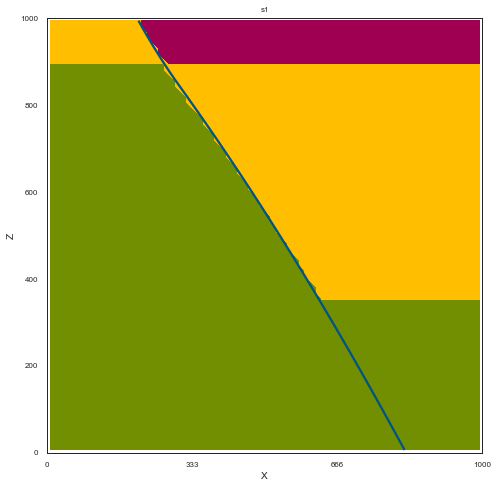

<Figure size 936x936 with 0 Axes>

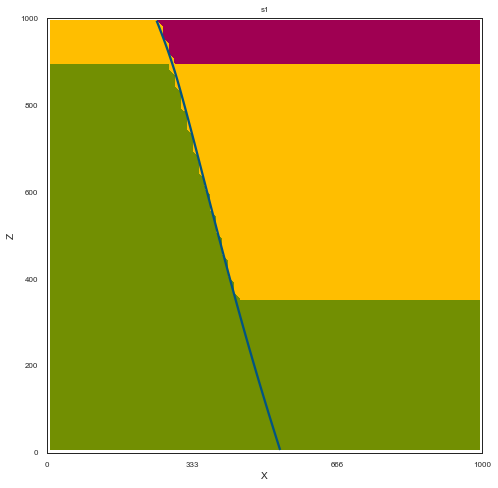

<Figure size 936x936 with 0 Axes>

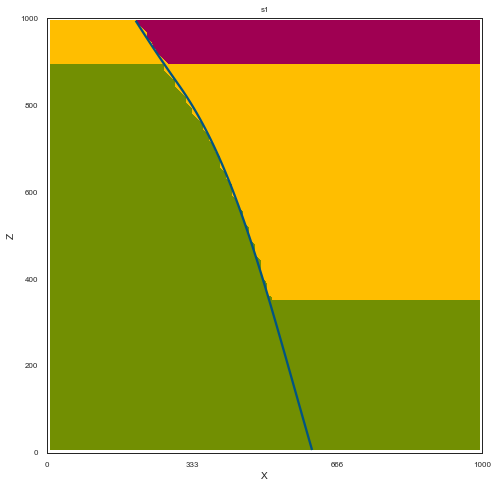

<Figure size 936x936 with 0 Axes>

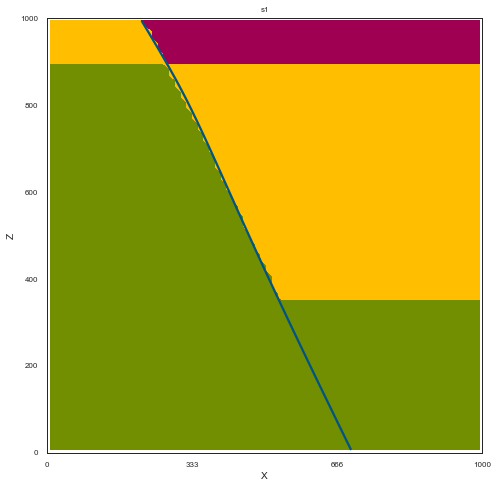

<Figure size 936x936 with 0 Axes>

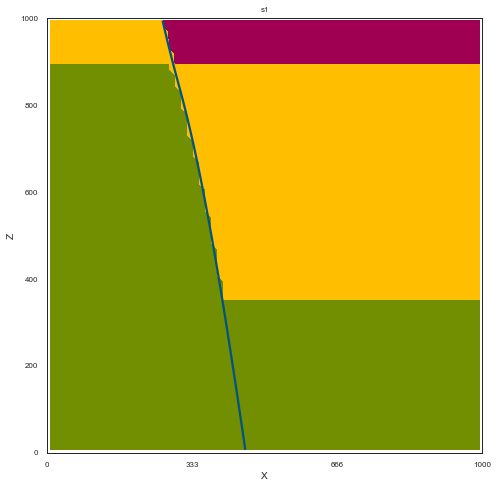

<Figure size 936x936 with 0 Axes>

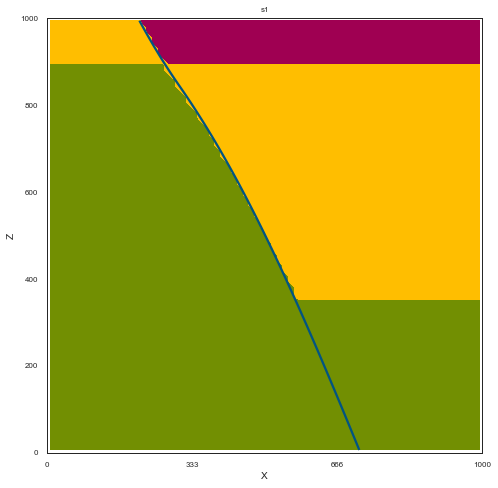

<Figure size 936x936 with 0 Axes>

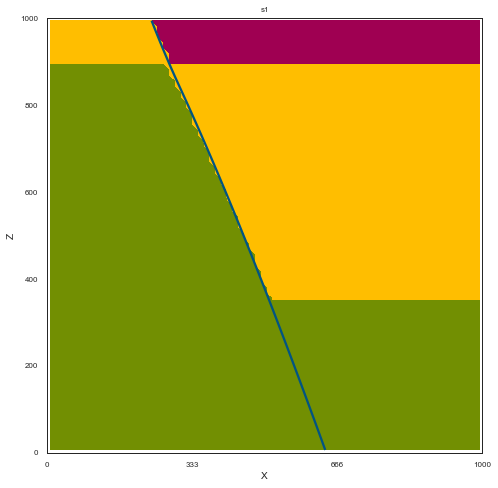

<Figure size 936x936 with 0 Axes>

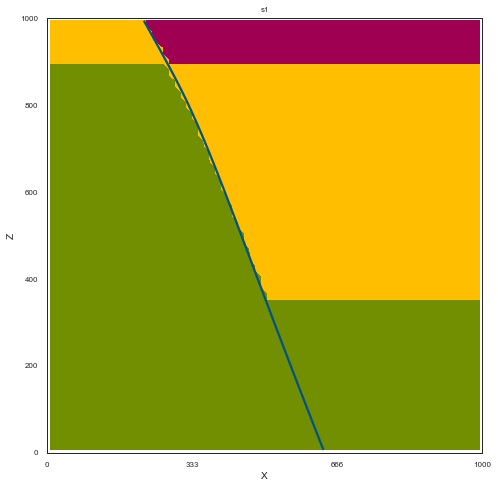

<Figure size 936x936 with 0 Axes>

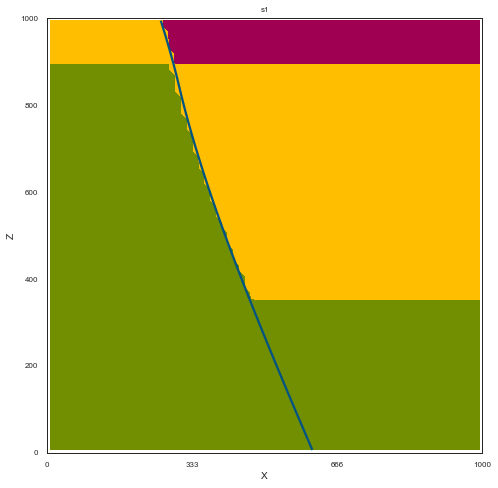

<Figure size 936x936 with 0 Axes>

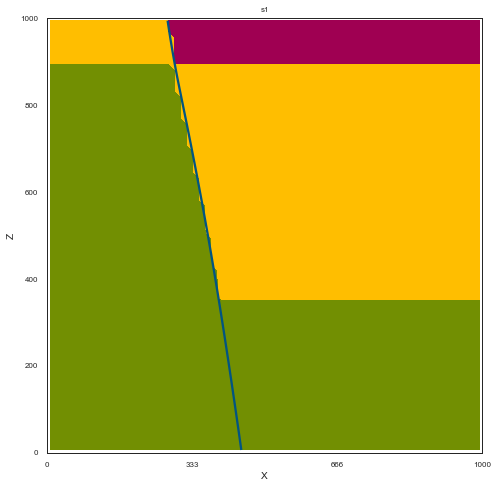

<Figure size 936x936 with 0 Axes>

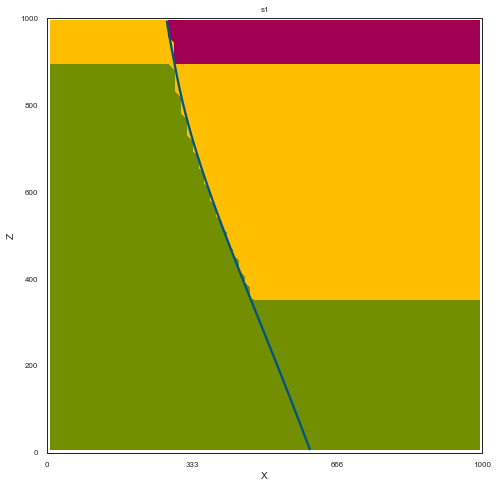

<Figure size 936x936 with 0 Axes>

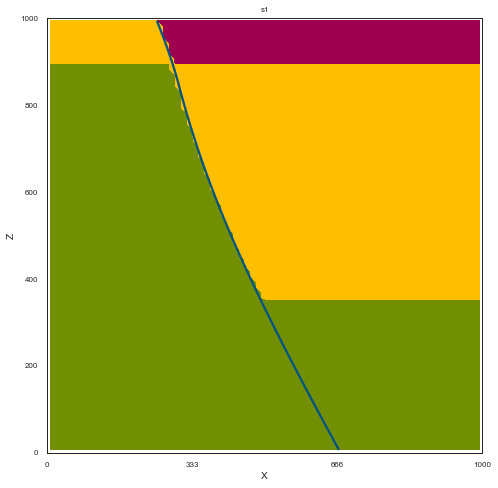

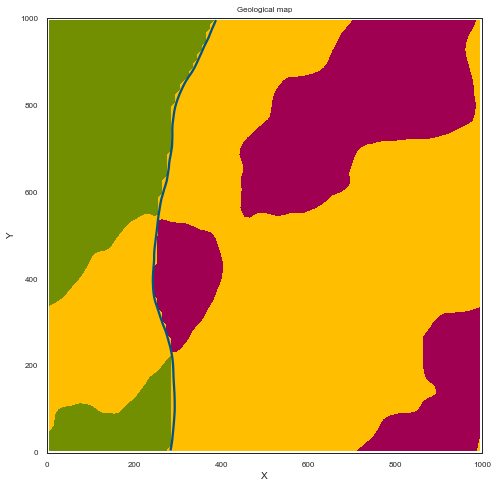

In [19]:
#### full simulation in loop
n_iter=12 #number of iterations
spaghetti = True # in case you want to create a spaghetti plot
                # only recommended up to 30 iterations because memory
for i in tqdm(range(n_iter)):
    plt.cla()
    plt.clf()
    
    # make virgin again
    geo_model.modify_surface_points(surfindexes, X=west_east, Y=north_south, Z=depth)
    geo_model.modify_orientations(orindexes, X=west_east_or, Y=north_south_or, Z=depth_or)
    geo_model.update_to_interpolator()
    
    if location_uncertainty ==True:
        rand_val = np.random.uniform(-50, 230)
        we = west_east[mask_surfpoints] + rand_val
        geo_model.modify_surface_points(indexes, X=we)
        geo_model.modify_orientations([0,3], X=we)
    if orientation_uncertainty==True:
        new_orientations = np.vstack(list(map(lambda x: x.sample(num_samples=1, 
                                                         direct_output=True)[0], 
                                      vMF_list)))
        a=fish.vMF()
        a.add_orientation_data(new_orientations)

        geo_model.modify_orientations(indexes_or,  G_x = new_orientations[:,0],
                                                G_y = new_orientations[:,1],
                                                G_z = new_orientations[:,2],
                                                azimuth = a.samples_azdip[:,0],
                                                dip = a.samples_azdip[:,1])  

    geo_model.update_to_interpolator()

    _=gp.compute_model(geo_model, compute_mesh=False)
    
    if spaghetti == True:
        polygondict, cdict, extent = section_utils.get_polygon_dictionary(geo_model, 's1')
        for form in polygondict.keys():
            polygondict_s1.get(form).append(polygondict.get(form))

        polygondict, cdict, extent = section_utils.get_polygon_dictionary(geo_model, 'topography')
        for form in polygondict.keys():
            polygondict_map.get(form).append(polygondict.get(form))
        
    ##### calculate and update probability fields #####
    geomap  = np.round(geo_model.solutions.geological_map[0]).astype(int)[0]
    section1  = np.round(geo_model.solutions.sections[0]).astype(int)[0]
    block = np.round(geo_model.solutions.lith_block).astype(int)
    
    
    for i, l_id in enumerate(lith_id): #enumerate through all liths
        count_map[i][geomap == l_id] += 1 #sum up frequency
        count_section[i][section1 == l_id] += 1 
        count_block[i][block == l_id] +=1 #block is raveled so no need for indexing

#### finish probability calculation and save as numpy arrays ####
prob_map = count_map/n_iter
prob_section = count_section/n_iter
prob_block = count_block/n_iter

#if location_uncertainty ==True:
#    np.save(r'probability_blocks/prob_map_loc',prob_map)
#    np.save(r'probability_blocks/prob_sections_loc',prob_section)
#    np.save(r'probability_blocks/prob_block_loc',prob_block)
    
#if orientation_uncertainty==True:
#    np.save(r'probability_blocks/prob_map_or',prob_map)
#    np.save(r'probability_blocks/prob_sections_or',prob_section)
#    np.save(r'probability_blocks/prob_block_or',prob_block)

## Visualize spaghetti

In [20]:
from gempy.plot import visualization_2d
plot=visualization_2d.PlotSolution(geo_model)

In [21]:
import matplotlib.patches as patches
from gempy.plot import visualization_2d
plot = visualization_2d.PlotSolution(geo_model)

import plot_pathdict as pp

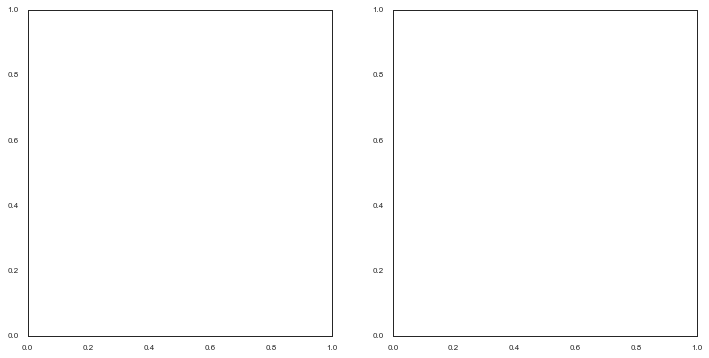

In [22]:
background = np.full((80,80),0.2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

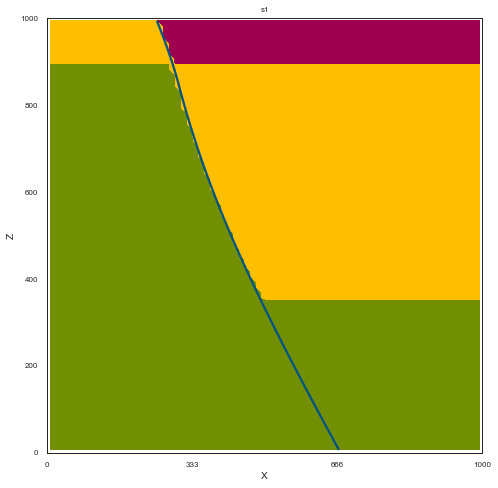

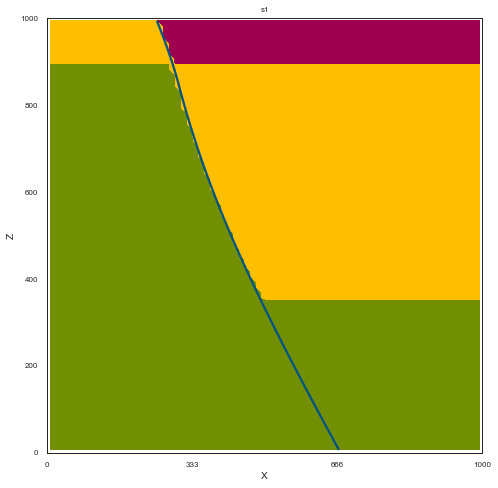

In [23]:
surflist = ['basement','layer1', 'layer2', 'fault']

extent=[0,1000,0,1000]
ax[0].imshow(background.T,cmap='gray',extent=extent,alpha=.2)
ax[1].imshow(background.T,cmap='gray',extent=extent,alpha=.2)
_, cdict, extent = section_utils.get_polygon_dictionary(geo_model, 's1')
pp.plot_pathdict(polygondict_s1, cdict, extent, ax[0], surflist)

_, cdict, extent = section_utils.get_polygon_dictionary(geo_model, 's1')
pp.plot_pathdict(polygondict_map, cdict, extent, ax[1], surflist)

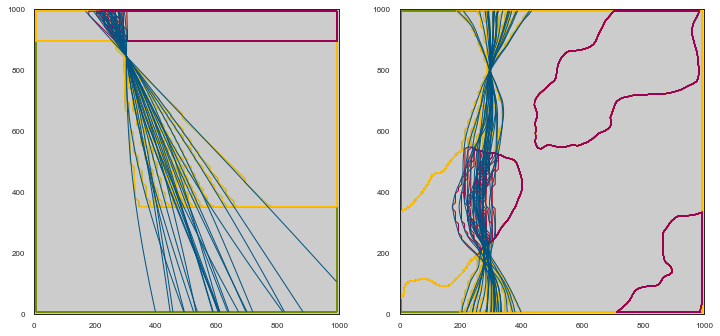

In [24]:
fig